# Correlation Modeling Notebook
This notebook utilizes the pandas library to create correlation matrices for nerfs/buffs and win rates.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import requests
import zipfile
import io

## Read Data
Note: This CSV file should have been downloaded from Dataverse in a previous Jupyter Notebook (note_sentences.ipynb).

In [2]:
df = pd.read_csv('patches.csv')
df.head()

,version,champion,note,win_rate
0,V10_1,Aphelios,Movement speed reduced to 325 from 330. Base h...,54.0
1,V10_1,Aphelios,Infernum splash damage reduced to 75% from 100%.,54.0
2,V10_1,Aurelion Sol,Base damage reduced to 12 − 120 (based on leve...,13.0
3,V10_1,Azir,Base damage increased to 175 / 325 / 475 from ...,46.0
4,V10_1,Corki,Base damage increased to 90 / 125 / 160 from 9...,46.0


## Lexicon-Based Classification

In [3]:
def get_label(text):
    # Not a string or empty string, return as neutral.
    if type(text) is not str or len(text) == 0:
        return 0
    
    # Keywords where if increased, it is positive.
    # Note: Require spaces before/after "ad" in case of certain words (e.g., "ADjusted" or "insteAD")
    norm = ['health', 'damage', 'movement speed', 'mana growth', 'mana per level', 'base mana', 'mana regeneration', 'mana restored', 'attack speed', ' ad ', ' ap ', 'ap scaling', 'duration', 'shield strength', 'heal', 'range', 'armor', 'lifesteal', 'life steal', 'spell vamp', 'slow', 'ability power', 'radius', 'magic reduction', 'gold', 'speed', 'stacks', 'per stack', 'magic resistance', 'hitbox']

    # Keywords where if increased, it is negative.
    inv_norm = ['mana cost', 'cooldown', 'shield decay', 'cost', 'reload time', 'windup', 'timer', 'delay', 'cast time']

    # Keywords for neutral changes.
    neutral = ['bug', 'fixed', 'new', 'changed', 'now', 'animation', 'updated', 'added', 'improved']

    # Positive keywords.
    positive = ['increased']

    # Negative keywords.
    negative = ['reduced', 'decreased', 'removed']
    
    text = text.lower()
    # Important to check for neutral keywords (e.g., "bux") first since patch might include norm/inv_norm keywords.
    if any(stat in text for stat in neutral):
        return 0
    # Grant will likely be positive.
    elif "grants" in text:
        return 1
    elif any(stat in text for stat in norm):
        if any(key in text for key in positive):
            return 1
        elif any(key in text for key in negative):
            return -1
        else:
            return 1
    elif any(stat in text for stat in inv_norm):
        if any(key in text for key in positive):
            return -1
        elif any(key in text for key in negative):
            return 1
        else:
            return -1
    else:
        return 0
            
    return 2

## Correlation Modeling

In [4]:
# Track list of champions.
champions = df.champion.unique()
champions

array(['Aphelios', 'Aurelion Sol', 'Azir', 'Corki', 'Draven', 'Illaoi',
       'Jax', 'Jayce', 'Kalista', 'Kassadin', 'Mordekaiser', 'Nami',
       'Sejuani', 'Shyvana', 'Sylas', 'Thresh', 'Varus', 'Vi', 'Warwick',
       'Yasuo', 'Zyra', 'Diana', 'Elise', 'Fiddlesticks', 'Galio',
       'Irelia', 'Kayn', 'Kled', 'Lissandra', 'Maokai', 'Miss Fortune',
       'Nidalee', 'Sett', 'Sivir', 'Soraka', 'Taric', 'Twisted Fate',
       'Wukong', 'Zed', 'Aatrox', 'Ashe', 'Caitlyn', 'Cassiopeia',
       'Ezreal', 'Gangplank', 'Gragas', 'Graves', 'Hecarim', 'Janna',
       'Jhin', 'Jinx', 'Lucian', 'Malzahar', 'Senna', 'Syndra',
       'Tristana', 'Twitch', 'Vayne', 'Xayah', 'Akali', 'Bard', 'Brand',
       'Braum', 'Ornn', 'Qiyana', 'Sion', 'Trundle', 'Viktor', 'Volibear',
       'Gnar', 'Malphite', 'Nautilus', 'Nocturne', 'Nunu', 'Rakan',
       'Ryze', 'Urgot', 'Yorick', 'Yuumi', 'Zoe', 'Alistar',
       'Heimerdinger', 'Ivern', 'Karthus', 'Leona', 'Neeko', 'Pyke',
       'Renekton', 'Riven', '

In [5]:
# Get unique patch versions.
patch_versions = df.version.unique()
patch_versions

array(['V10_1', 'V10_10', 'V10_11', 'V10_12', 'V10_13', 'V10_14',
       'V10_15', 'V10_16', 'V10_18', 'V10_19', 'V10_2', 'V10_20',
       'V10_21', 'V10_22', 'V10_25', 'V10_3', 'V10_4', 'V10_5', 'V10_6',
       'V10_7', 'V10_8', 'V11_1', 'V11_10', 'V11_11', 'V11_12', 'V11_13',
       'V11_14', 'V11_15', 'V11_16', 'V11_17', 'V11_18', 'V11_19',
       'V11_2', 'V11_20', 'V11_21', 'V11_22', 'V11_23', 'V11_24', 'V11_3',
       'V11_4', 'V11_5', 'V11_6', 'V11_7', 'V11_9', 'V12_1', 'V12_10',
       'V12_11', 'V12_12', 'V12_13', 'V12_14', 'V12_15', 'V12_16',
       'V12_18', 'V12_2', 'V12_3', 'V12_4', 'V12_5', 'V12_6', 'V12_8',
       'V12_9', 'V13_1', 'V13_10', 'V13_11', 'V13_12', 'V13_13', 'V13_14',
       'V13_15', 'V13_17', 'V13_19', 'V13_24', 'V13_3', 'V13_4', 'V13_5',
       'V13_6', 'V13_7', 'V13_8', 'V14_1', 'V14_2', 'V14_3', 'V14_4',
       'V14_5', 'V14_6', 'V14_7', 'V14_8', 'V5_23', 'V5_24', 'V6_1',
       'V6_10', 'V6_11', 'V6_12', 'V6_13', 'V6_14', 'V6_15', 'V6_16',
       'V6_1

In [6]:
# Sort patch versions from earliest to latest.
def convertPatchToDecimal(patch):
    major, minor = patch[1:].split('_')
    return int(major) * 1000 + int(minor)

patch_versions = list(patch_versions)
patch_versions.sort(key=convertPatchToDecimal)

In [7]:
print(patch_versions)

['V5_23', 'V5_24', 'V6_1', 'V6_2', 'V6_3', 'V6_4', 'V6_5', 'V6_7', 'V6_8', 'V6_10', 'V6_11', 'V6_12', 'V6_13', 'V6_14', 'V6_15', 'V6_16', 'V6_18', 'V6_21', 'V6_23', 'V7_1', 'V7_2', 'V7_3', 'V7_4', 'V7_5', 'V7_6', 'V7_7', 'V7_8', 'V7_10', 'V7_11', 'V7_12', 'V7_13', 'V7_14', 'V7_15', 'V7_16', 'V7_17', 'V7_18', 'V7_22', 'V7_23', 'V8_1', 'V8_2', 'V8_3', 'V8_4', 'V8_5', 'V8_6', 'V8_8', 'V8_10', 'V8_11', 'V8_12', 'V8_13', 'V8_14', 'V8_15', 'V8_16', 'V8_17', 'V8_19', 'V8_20', 'V8_21', 'V8_22', 'V8_23', 'V8_24', 'V9_1', 'V9_2', 'V9_3', 'V9_4', 'V9_5', 'V9_6', 'V9_7', 'V9_8', 'V9_10', 'V9_11', 'V9_12', 'V9_13', 'V9_14', 'V9_15', 'V9_17', 'V9_19', 'V9_21', 'V9_23', 'V9_24', 'V10_1', 'V10_2', 'V10_3', 'V10_4', 'V10_5', 'V10_6', 'V10_7', 'V10_8', 'V10_10', 'V10_11', 'V10_12', 'V10_13', 'V10_14', 'V10_15', 'V10_16', 'V10_18', 'V10_19', 'V10_20', 'V10_21', 'V10_22', 'V10_25', 'V11_1', 'V11_2', 'V11_3', 'V11_4', 'V11_5', 'V11_6', 'V11_7', 'V11_9', 'V11_10', 'V11_11', 'V11_12', 'V11_13', 'V11_14', 'V1

In [8]:
# For each patch, determine each champion's # of buffs / nerfs and win rate.
# Note: buffs / nerfs are just calculated as the sum, where buffs are +1 and nerfs are -1.
buffs_nerfs = {}  # Keyed on champion name, value is list of buffs / nerfs, one item for each patch.
win_rates = {}  # Keyed on champion name, value is list of win rates, one item for each patch.
patches_ran = []
for patch in patch_versions:
    # For progress tracking only.
    if patch.split('_')[0] not in patches_ran:
        print('Running patch {}...'.format(patch.split('_')[0]))
        patches_ran.append(patch.split('_')[0])
    
    # For each champion, track buffs / nerfs and win rate.
    for champion in champions:
        # Get all entries of current patch version and champion.
        rows = df.loc[(df['version'] == patch) & (df['champion'] == champion)]
        rows = rows.reset_index(drop=True)
        
        # Save win rate for this patch and champion.
        win_rate = -1
        if len(rows) > 0:  # Check to ensure that champion data exists for current patch.
            # Just take first row's win rate since all are the same.
            if not math.isnan(rows.iloc[0]['win_rate']):
                win_rate = rows.iloc[0]['win_rate']
        
        key = champion + "_win"  # Win rate should have different keys than buffs_nerfs b/c these lists will be merged later.
        if key not in win_rates:
            win_rates[key] = [win_rate]
        else:
            win_rates[key].append(win_rate)
        
        # Determine the number of buffs or nerfs.
        buffs_nerfs_count = -1
        if len(rows) > 0:  # Check to ensure that champion data exists for current patch.
            buffs_nerfs_count = 0
            for i in range(len(rows)):
                row = rows.iloc[i]
                buffs_nerfs_count += get_label(row['note'])
            
        # Save this number of buffs or nerfs.
        if champion not in buffs_nerfs:
            buffs_nerfs[champion] = [buffs_nerfs_count]
        else:
            buffs_nerfs[champion].append(buffs_nerfs_count)
            
# print(buffs_nerfs)
# print(win_rates)

Running patch V5...
Running patch V6...
Running patch V7...
Running patch V8...
Running patch V9...
Running patch V10...
Running patch V11...
Running patch V12...
Running patch V13...
Running patch V14...


In [9]:
# Create new dataframe with both the buffs/nerfs and win rates.
df_corr = pd.DataFrame({**buffs_nerfs, **win_rates})
df_corr.head()

,Aphelios,Aurelion Sol,Azir,Corki,Draven,Illaoi,Jax,Jayce,Kalista,Kassadin,...,Zac_win,Zeri_win,Nilah_win,Milio_win,Naafiri_win,Hwei_win,Rammus_win,Smolder_win,Briar_win,Master Yi_win
0,-1,-1,0,-1,-1,-1,-1,-1,-1,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-1,-1,0,-1,-1,-1,-1,-1,-1,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1,-1,-1,-1,-1,-1,-1,0,1,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [10]:
# Using numpy...

# Create correlation matrix, showing relationships between champion-specific buffs/nerfs and win rates.
# Swap variables as rows since corrcoef assumes each row represents a variable, and each column a single observation of all vars.
correlations = np.corrcoef(df_corr.swapaxes('index', 'columns'))
correlations

array([[ 1.        ,  0.0234468 ,  0.04004026, ..., -0.0301701 ,
        -0.01529159, -0.01665695],
       [ 0.0234468 ,  1.        ,  0.19185806, ..., -0.10765722,
        -0.00761895,  0.21578017],
       [ 0.04004026,  0.19185806,  1.        , ..., -0.05916181,
        -0.03045112, -0.02299288],
       ...,
       [-0.0301701 , -0.10765722, -0.05916181, ...,  1.        ,
         0.39138375, -0.01334877],
       [-0.01529159, -0.00761895, -0.03045112, ...,  0.39138375,
         1.        , -0.00676577],
       [-0.01665695,  0.21578017, -0.02299288, ..., -0.01334877,
        -0.00676577,  1.        ]])

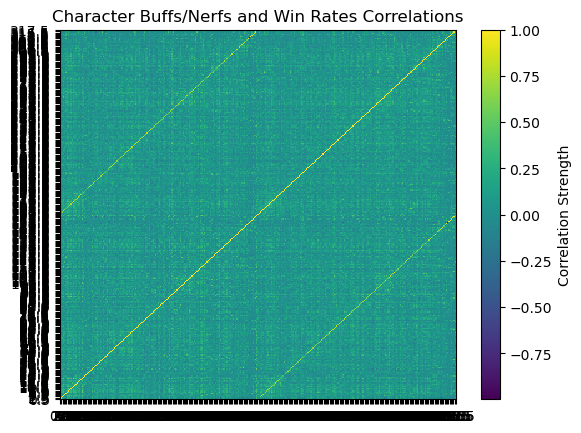

In [11]:
# Create a heatmap showing the correlations.
fig, ax = plt.subplots()
heatmap = ax.pcolor(correlations)

# Include a color bar.
color_bar = plt.colorbar(heatmap)
color_bar.set_label('Correlation Strength')

# Center ticks in the center of the grid unit.
ax.set_xticks(np.arange(correlations.shape[1]) + 0.5)
ax.set_yticks(np.arange(correlations.shape[0]) + 0.5)

plt.title('Character Buffs/Nerfs and Win Rates Correlations')
plt.show()

In [12]:
# Using pandas...

# Create correlation matrix, showing relationships between champion-specific buffs/nerfs and win rates.
correlation_matrix = df_corr.corr()
correlation_matrix

,Aphelios,Aurelion Sol,Azir,Corki,Draven,Illaoi,Jax,Jayce,Kalista,Kassadin,...,Zac_win,Zeri_win,Nilah_win,Milio_win,Naafiri_win,Hwei_win,Rammus_win,Smolder_win,Briar_win,Master Yi_win
Aphelios,1.000000,0.023447,0.040040,-0.047171,-0.105366,-0.012524,-0.042847,-0.001993,-0.090191,0.054215,...,-0.053877,0.082279,-0.025302,0.047132,-0.015292,-0.035798,-0.030950,-0.030170,-0.015292,-0.016657
Aurelion Sol,0.023447,1.000000,0.191858,0.148206,0.097585,-0.099844,0.243118,0.272446,0.163408,0.166322,...,-0.024785,-0.084062,-0.012607,-0.010790,-0.007619,-0.079794,0.088412,-0.107657,-0.007619,0.215780
Azir,0.040040,0.191858,1.000000,0.136633,0.038598,0.063486,0.242374,0.157722,0.310224,0.110939,...,0.013349,-0.005551,0.038286,-0.043123,-0.030451,-0.108893,0.051548,-0.059162,-0.030451,-0.022993
Corki,-0.047171,0.148206,0.136633,1.000000,0.118117,0.076804,0.388297,0.379951,0.239795,0.341654,...,0.177874,-0.004885,-0.041774,-0.035753,-0.025246,-0.015109,0.243813,0.015959,-0.025246,-0.000982
Draven,-0.105366,0.097585,0.038598,0.118117,1.000000,-0.006598,0.021245,0.029501,0.341248,0.013639,...,-0.019615,0.031571,-0.048321,0.067361,-0.029203,0.157206,0.023235,-0.057618,-0.029203,0.301380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hwei_win,-0.035798,-0.079794,-0.108893,-0.015109,0.157206,0.324690,-0.053685,0.098455,-0.062373,-0.057924,...,0.132050,0.025054,0.259208,-0.020592,-0.014541,1.000000,0.151351,0.403746,0.350507,-0.015839
Rammus_win,-0.030950,0.088412,0.051548,0.243813,0.023235,0.328574,0.154492,0.271822,0.127623,0.192705,...,0.075172,-0.048201,0.380884,-0.017803,-0.012571,0.151351,1.000000,-0.024803,-0.012571,0.009357
Smolder_win,-0.030170,-0.107657,-0.059162,0.015959,-0.057618,0.198242,0.045995,0.081527,-0.052566,-0.048817,...,0.070525,0.073816,-0.020277,-0.017354,-0.012255,0.403746,-0.024803,1.000000,0.391384,-0.013349
Briar_win,-0.015292,-0.007619,-0.030451,-0.025246,-0.029203,0.162791,-0.022932,0.292040,-0.026643,-0.024743,...,0.149332,-0.023815,-0.010277,-0.008796,-0.006211,0.350507,-0.012571,0.391384,1.000000,-0.006766


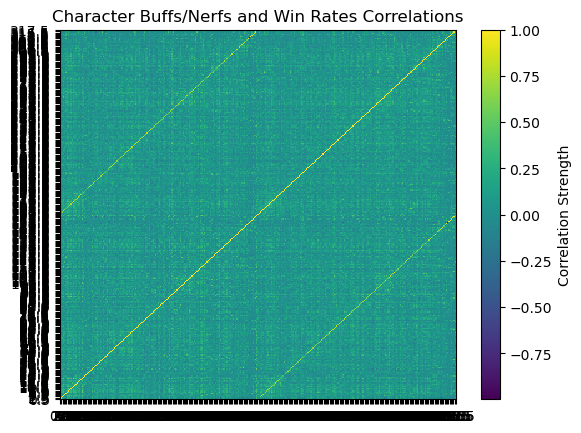

In [13]:
# Create a heatmap showing the correlations.

# Create correlation matrix, showing relationships between champion-specific buffs/nerfs and win rates.
# Swap variables as rows since corrcoef assumes each row represents a variable, and each column a single observation of all vars.

fig, ax = plt.subplots()
heatmap = ax.pcolor(correlation_matrix)

# Include a color bar.
color_bar = plt.colorbar(heatmap)
color_bar.set_label('Correlation Strength')

# Center ticks in the center of the grid unit.
ax.set_xticks(np.arange(correlation_matrix.shape[1]) + 0.5)
ax.set_yticks(np.arange(correlation_matrix.shape[0]) + 0.5)

plt.title('Character Buffs/Nerfs and Win Rates Correlations')
plt.show()

In [14]:
# Only looking at a few champions so the heatmap is legible.
truncated_corr_matrix = correlation_matrix.loc['Aphelios_win':'Draven_win', 'Aphelios':'Draven']
truncated_corr_matrix

,Aphelios,Aurelion Sol,Azir,Corki,Draven
Aphelios_win,0.415009,0.033816,0.137512,0.020702,0.279433
Aurelion Sol_win,-0.006714,0.079987,0.027062,-0.016990,0.117831
Azir_win,0.007987,0.111430,0.647683,0.137678,0.123926
Corki_win,-0.052909,0.098122,0.057435,0.817294,0.071686
Draven_win,0.032880,0.114203,0.059744,0.188809,0.726053


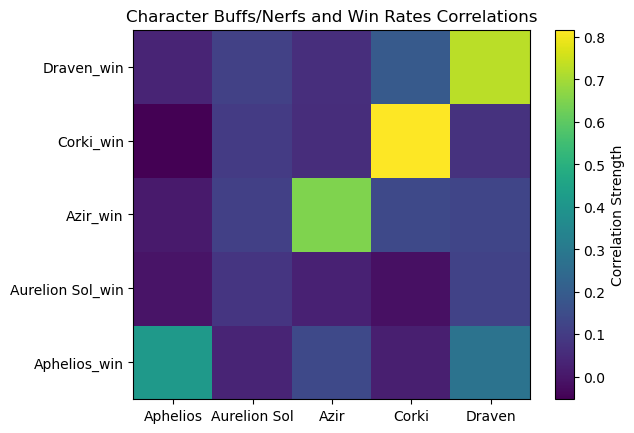

In [15]:
# Create a heatmap showing the correlations.

# Create correlation matrix, showing relationships between champion-specific buffs/nerfs and win rates.
# Swap variables as rows since corrcoef assumes each row represents a variable, and each column a single observation of all vars.

fig, ax = plt.subplots()
heatmap = ax.pcolor(truncated_corr_matrix)

# Include a color bar.
color_bar = plt.colorbar(heatmap)
color_bar.set_label('Correlation Strength')

# Center ticks in the center of the grid unit.
ax.set_xticks(np.arange(truncated_corr_matrix.shape[1]) + 0.5)
ax.set_yticks(np.arange(truncated_corr_matrix.shape[0]) + 0.5)
# Label the ticks as the champion (specifying either buffs/nerfs or win rates).
x_axis_labels = ['Aphelios', 'Aurelion Sol', 'Azir', 'Corki', 'Draven']
y_axis_labels = ['Aphelios_win', 'Aurelion Sol_win', 'Azir_win', 'Corki_win', 'Draven_win']
ax.set_xticklabels(x_axis_labels)
ax.set_yticklabels(y_axis_labels)

plt.title('Character Buffs/Nerfs and Win Rates Correlations')
plt.show()

In [16]:
# Only looking at a one champions buffs/nerfs and its influence on other champions' win rates.
# All Champions: specific_corr_matrix = correlation_matrix.loc['Aphelios_win':'Master Yi_win', ['Aphelios']]
specific_corr_matrix = correlation_matrix.loc['Aphelios_win':'Draven_win', ['Draven']]

# Changes for visualization purposes.
specific_corr_matrix = specific_corr_matrix.transpose()
specific_corr_matrix.columns = specific_corr_matrix.columns.str.replace('_win', ' (WR)')

specific_corr_matrix

,Aphelios (WR),Aurelion Sol (WR),Azir (WR),Corki (WR),Draven (WR)
Draven,0.279433,0.117831,0.123926,0.071686,0.726053


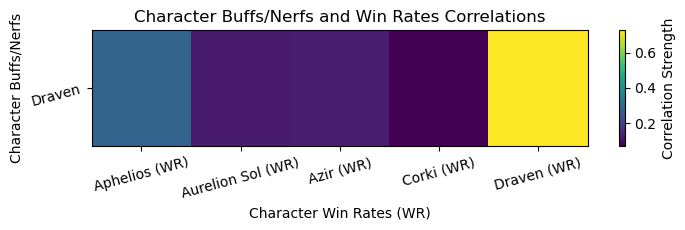

In [17]:
# Create a heatmap showing the correlations.

# Create correlation matrix, showing relationships between champion-specific buffs/nerfs and win rates.
# Swap variables as rows since corrcoef assumes each row represents a variable, and each column a single observation of all vars.

fig, ax = plt.subplots(figsize=(8, 1.5))
heatmap = ax.pcolor(specific_corr_matrix)

# Include a color bar.
color_bar = plt.colorbar(heatmap)
color_bar.set_label('Correlation Strength')

# Center ticks in the center of the grid unit.
ax.set_xticks(np.arange(specific_corr_matrix.shape[1]) + 0.5)
ax.set_yticks(np.arange(specific_corr_matrix.shape[0]) + 0.5)
# Label the ticks as the champion (specifying either buffs/nerfs or win rates).
x_axis_labels = specific_corr_matrix.columns
y_axis_labels = specific_corr_matrix.index.values
ax.set_xticklabels(x_axis_labels, rotation=15)
ax.set_yticklabels(y_axis_labels, rotation=15)
ax.set_xlabel('Character Win Rates (WR)')
ax.set_ylabel('Character Buffs/Nerfs')

plt.title('Character Buffs/Nerfs and Win Rates Correlations')
plt.show()